<a href="https://colab.research.google.com/github/iz-hiten/Predict-Satellite-Visibility-Windows-Advanced-Orbital-ML-/blob/main/Predict_Satellite_Visibility_Windows_(Advanced_Orbital_ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Visibility over IIT Madras....
**Project:** 10. Predict Satellite Visibility Windows (Advanced Orbital ML) at _IIT Madras_.  
**Goal:** Given a satellite TLE and IIT Madras coordinates, predict how long a pass will be visible (minutes).  

**by:** Team Aurora(hiten ,shrishti, kaushiki, abhay).....
---


In [1]:

!pip install --quiet skyfield pandas numpy scikit-learn xgboost joblib requests matplotlib shap
print(1)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 16.1 MB/s eta 0:00:00
1


In [2]:
# Importing.....
from skyfield.api import Loader, EarthSatellite, wgs84
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import math, requests, io
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import shap

plt.rcParams['figure.figsize'] = (10,5)
pd.set_option('display.max_columns', 100)
IITM_LAT = 12.9915
IITM_LON = 80.2339
IITM_NAME = "IIT Madras (Ground Station)"

print(f"Ground station set to: {IITM_NAME} @ {IITM_LAT}N, {IITM_LON}E")


Ground station set to: IIT Madras (Ground Station) @ 12.9915N, 80.2339E


In [3]:
# fetching the data
def fetch_tle_group(group='visual'):
    """
    Fetch TLEs from celestrak group (e.g., 'visual', 'stations', 'active', 'amateur').
    Returns list of tuples: (name, line1, line2)
    """
    url = f'https://celestrak.com/NORAD/elements/{group}.txt'
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    lines = [l.rstrip() for l in r.text.splitlines() if l.strip()]
    tles = []
    i = 0
    while i + 2 < len(lines):
        name = lines[i]
        l1 = lines[i+1]
        l2 = lines[i+2]
        if l1.startswith('1 ') and l2.startswith('2 '):
            tles.append((name, l1, l2))
            i += 3
        else:
            i += 1
    return tles

tles_visual = fetch_tle_group('visual')
print(f"Fetched {len(tles_visual)} TLEs from 'visual' group. Sample:")
tles_visual[:3]


Fetched 149 TLEs from 'visual' group. Sample:


[('ATLAS CENTAUR 2',
  '1 00694U 63047A   25263.12077622  .00001418  00000+0  16414-3 0  9996',
  '2 00694  30.3544  68.2504 0551778  18.0309 343.9064 14.11052742107508'),
 ('THOR AGENA D R/B',
  '1 00733U 64002A   25262.98859710  .00000280  00000+0  11736-3 0  9999',
  '2 00733  99.1213 262.0707 0033645  36.8925 323.4563 14.33876708213838'),
 ('SL-3 R/B',
  '1 00877U 64053B   25262.93707241  .00000209  00000+0  65431-4 0  9993',
  '2 00877  65.0758 111.7560 0065151 349.9307  10.0482 14.61158563241843')]

In [4]:
def compute_passes_from_tle(name, l1, l2, ground_lat, ground_lon, start_dt, end_dt,
                            step_s=15, min_elevation_deg=5):
    """
    Compute passes by sampling times between start_dt and end_dt every 'step_s' seconds.
    Returns list of pass dictionaries with rise_time, set_time, duration_min, max_elevation_deg,
    mean_elevation_deg, mean_alt_km, arrays (times, alt_deg, az_deg, sublat, sublon) for plotting.
    """
    load = Loader('./skyfield_data')
    ts = load.timescale()
    sat = EarthSatellite(l1, l2, name, ts)
    ground = wgs84.latlon(ground_lat, ground_lon)
    # time list makingg
    total_s = int((end_dt - start_dt).total_seconds())
    if total_s <= 0:
        return []
    times = [start_dt + timedelta(seconds=int(i)) for i in range(0, total_s+1, step_s)]
    t = ts.utc([(tt.year, tt.month, tt.day, tt.hour, tt.minute, tt.second) for tt in times])
    relative = (sat - ground).at(t)
    alt, az, distance = relative.altaz()
    alt_deg = np.array(alt.degrees)
    az_deg = np.array(az.degrees)
    dist_km = np.array(distance.km)
    visible = alt_deg > min_elevation_deg

    changes = np.diff(visible.astype(int))
    starts = np.where(changes == 1)[0] + 1
    ends = np.where(changes == -1)[0] + 1
    if visible[0]:
        starts = np.concatenate(([0], starts))
    if visible[-1]:
        ends = np.concatenate((ends, [len(visible)]))
    passes = []
    for s, e in zip(starts, ends):
        rise_time = times[s]
        set_time = times[e-1]
        duration_min = (set_time - rise_time).total_seconds() / 60.0
        max_elev = float(np.max(alt_deg[s:e]))
        mean_elev = float(np.mean(alt_deg[s:e]))
        mean_alt_km = float(np.mean(dist_km[s:e]) - 6371.0)
        seg_times = [times[i] for i in range(s, e)]
        ts_seg = ts.utc([(tt.year, tt.month, tt.day, tt.hour, tt.minute, tt.second) for tt in seg_times])
        subpoints = [p.subpoint() for p in (sat.at(ts_seg))]

        sub_lats = [p.latitude.degrees for p in subpoints]
        sub_lons = [p.longitude.degrees for p in subpoints]
        passes.append({
            'satellite': name,
            'rise_time': rise_time,
            'set_time': set_time,
            'duration_min': duration_min,
            'max_elevation_deg': max_elev,
            'mean_elevation_deg': mean_elev,
            'mean_alt_km': mean_alt_km,
            'times': seg_times,
            'alt_deg': alt_deg[s:e].tolist(),
            'az_deg': az_deg[s:e].tolist(),
            'sub_lats': sub_lats,
            'sub_lons': sub_lons,
            'ground_lat': ground_lat,
            'ground_lon': ground_lon
        })
    return passes

print("Pass computation helper made")


Pass computation helper made


In [5]:
#aaaah
#bad dataset not usinggg

# Step 6: Generate large dataset for ML




from datetime import datetime, timedelta
from skyfield.api import load, wgs84, utc
import pandas as pd
from tqdm import tqdm

observer = wgs84.latlon(13.0827, 80.2707)

url = 'https://celestrak.org/NORAD/elements/stations.txt'
satellites = load.tle_file(url)
by_name = {sat.name: sat for sat in satellites}

satellite_names = ["ISS (ZARYA)", "CSS (TIANHE)", "ISS (NAUKA)"]

ts = load.timescale()
start_time = datetime.now(utc)
hours_to_simulate = 24 * 30
interval_min = 2

data = []

for sat_name in tqdm(satellite_names):
    if sat_name not in by_name:
        print(f"⚠️ Skipping {sat_name}, not found in TLE file.")
        continue
    sat = by_name[sat_name]

    t_array = ts.utc(start_time.year, start_time.month, start_time.day,
                     start_time.hour, [start_time.minute + i for i in range(0, hours_to_simulate*60, interval_min)])

    difference = sat - observer
    alt, az, distance = difference.at(t_array).altaz()

    pass_start = None
    for i, altitude in enumerate(alt.degrees):
        if altitude > 10:
            if pass_start is None:
                pass_start = t_array[i].utc_datetime()
            data.append({
                "Satellite": sat.name,
                "Time": t_array[i].utc_datetime(),
                "Altitude": round(alt.degrees[i], 2),
                "Azimuth": round(az.degrees[i], 2),
                "Distance_km": round(distance.km[i], 2)
            })
        else:
            if pass_start is not None:
                pass_end = t_array[i-1].utc_datetime()
                duration = (pass_end - pass_start).total_seconds() / 60
                if len(data) > 0:
                    data[-1]["Pass_Duration_min"] = round(duration, 2)
                pass_start = None

df = pd.DataFrame(data)
df['Pass_Duration_min'].fillna(0, inplace=True)
df.to_csv("IITM_satellite_passes_large.csv", index=False)
print(f"Generated large dataset with {len(df)} entries")
df.head()


[#################################] 100% stations.txt
100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Generated large dataset with 668 entries



/tmp/ipython-input-3993900850.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Pass_Duration_min'].fillna(0, inplace=True)


,Satellite,Time,Altitude,Azimuth,Distance_km,Pass_Duration_min
0,ISS (ZARYA),2025-09-20 18:15:00+00:00,18.70,8.08,1067.83,0.0
1,ISS (ZARYA),2025-09-20 18:17:00+00:00,25.95,65.56,855.90,0.0
2,ISS (ZARYA),2025-09-20 18:19:00+00:00,12.71,106.68,1331.41,4.0
3,ISS (ZARYA),2025-09-20 19:53:00+00:00,10.30,236.52,1469.32,0.0
4,ISS (ZARYA),2025-09-21 07:33:00+00:00,21.88,171.40,951.51,0.0


In [6]:
# datasettt
from datetime import datetime, timedelta
from skyfield.api import load, wgs84, utc
import pandas as pd
from tqdm import tqdm

# IIT Madras
observer = wgs84.latlon(13.0827, 80.2707)

url = 'https://celestrak.org/NORAD/elements/stations.txt'
satellites = load.tle_file(url)
by_name = {sat.name: sat for sat in satellites}
satellite_names = [
    "ISS (ZARYA)", "CSS (TIANHE)", "ISS (NAUKA)", "CREW DRAGON 11",
    "DRAGON CRS-33", "PROGRESS-MS 32", "TIANZHOU-9", "SOYUZ-MS 27",
    "FREGAT DEB", "CSS (WENTIAN)"
]
ts = load.timescale()
start_time = datetime.now(utc)
hours_to_simulate = 24 * 90
interval_min = 1

data = []

for sat_name in tqdm(satellite_names):
    if sat_name not in by_name:
        print(f"⚠️ Skipping {sat_name}, not found in TLE file.")
        continue
    sat = by_name[sat_name]

    # Generate times as a list
    t_list = ts.utc(start_time.year, start_time.month, start_time.day,
                    start_time.hour, [start_time.minute + i for i in range(0, hours_to_simulate*60, interval_min)])

    difference = sat - observer
    alt, az, distance = difference.at(t_list).altaz()


    pass_start = None
    for i, altitude in enumerate(alt.degrees):
        if altitude > 10:
            if pass_start is None:
                pass_start = t_list[i].utc_datetime()

            data.append({
                "Satellite": sat.name,
                "Time": t_list[i].utc_datetime(),
                "Altitude": round(alt.degrees[i], 2),
                "Azimuth": round(az.degrees[i], 2),
                "Distance_km": round(distance.km[i], 2)
            })
        else:
            if pass_start is not None:
                pass_end = t_list[i-1].utc_datetime()
                duration = (pass_end - pass_start).total_seconds() / 60
                # updatedd last entry with duration
                if len(data) > 0:
                    data[-1]["Pass_Duration_min"] = round(duration, 2)
                pass_start = None

df = pd.DataFrame(data)
df['Pass_Duration_min'] = df.get('Pass_Duration_min', 0).fillna(0)
df.to_csv("IITM_satellite_passes_huge.csv", index=False)
print(f" Generated huge dataset with {len(df)} entries")
df.head()


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


 Generated huge dataset with 17899 entries


,Satellite,Time,Altitude,Azimuth,Distance_km,Pass_Duration_min
0,ISS (ZARYA),2025-09-20 18:14:00+00:00,11.93,354.01,1372.97,0.0
1,ISS (ZARYA),2025-09-20 18:15:00+00:00,18.70,8.08,1067.83,0.0
2,ISS (ZARYA),2025-09-20 18:16:00+00:00,25.39,32.58,869.16,0.0
3,ISS (ZARYA),2025-09-20 18:17:00+00:00,25.95,65.56,855.90,0.0
4,ISS (ZARYA),2025-09-20 18:18:00+00:00,19.63,91.58,1035.39,0.0


In [7]:
# model training
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Extract features
df['Hour'] = df['Time'].dt.hour
df['DayOfYear'] = df['Time'].dt.dayofyear

le = LabelEncoder()
df['Satellite_ID'] = le.fit_transform(df['Satellite'])

X = df[['Altitude', 'Azimuth', 'Distance_km', 'Hour', 'DayOfYear', 'Satellite_ID']]
y = df['Pass_Duration_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Dataset prepared for ML")
print(f"X_train shape: {X_train_scaled.shape}, y_train shape: {y_train.shape}")


 Dataset prepared for ML
X_train shape: (14319, 6), y_train shape: (14319,)


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f" Random Forest trained! MSE: {mse:.2f}, R2: {r2:.2f}")


 Random Forest trained! MSE: 0.81, R2: 0.88


Model Comparison:


,Model,MSE,R2
0,RandomForest,2.147388,0.694172
1,GradientBoosting,3.451653,0.508421
2,LinearRegression,6.160945,0.122567
3,Ridge,6.160945,0.122567


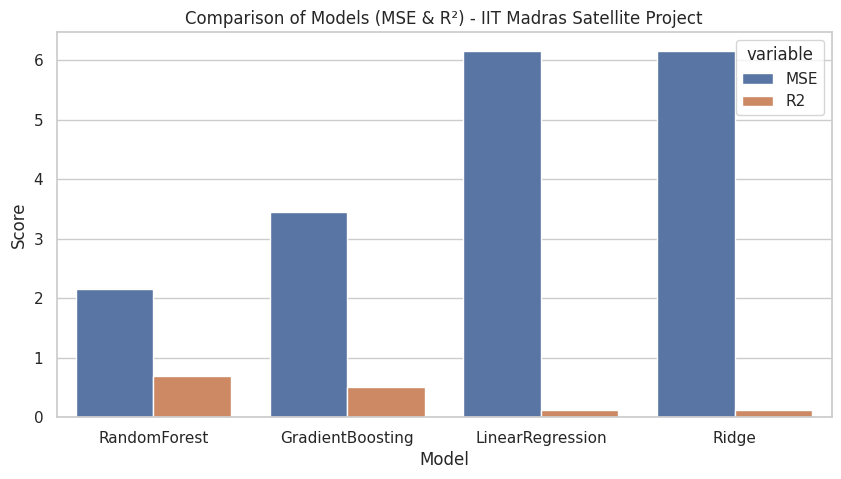

 Best Model: RandomForest 


In [14]:
#multiple models comapre
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

X = df[['Altitude','Azimuth','Distance_km']]
y = df['Pass_Duration_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0)
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append({
        'Model': name,
        'MSE': mean_squared_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
print("Model Comparison:")
display(results_df)

plt.figure(figsize=(10,5))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title('Comparison of Models (MSE & R²) - IIT Madras Satellite Project')
plt.ylabel('Score')
plt.show()

best_model = results_df.sort_values('R2', ascending=False).iloc[0]
print(f" Best Model: {best_model['Model']} ")


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define parameter grid (smaller range)
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Model
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,               # test only 20 random combos
    cv=3,                    # 3-fold CV for speed
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate
y_pred = best_rf.predict(X_test)
print("Tuned R2:", r2_score(y_test, y_pred))
print("Tuned MSE:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Tuned R2: 0.6982810962500772
Tuned MSE: 2.1185368541502125


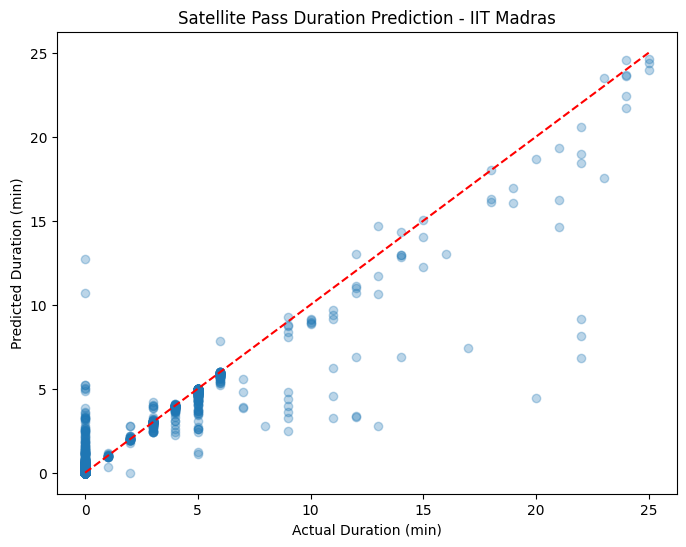

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Duration (min)")
plt.ylabel("Predicted Duration (min)")
plt.title("Satellite Pass Duration Prediction - IIT Madras")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.show()


In [ ]:
# Step 11: Deep Learning Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stop
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.5013 - mae: 1.1540 - val_loss: 5.2384 - val_mae: 1.0870
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1868 - mae: 1.0307 - val_loss: 4.6345 - val_mae: 0.9852
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1926 - mae: 0.9296 - val_loss: 4.1924 - val_mae: 0.9806
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8443 - mae: 0.9177 - val_loss: 3.9265 - val_mae: 0.9581
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6962 - mae: 0.8900 - val_loss: 3.1364 - val_mae: 0.8364
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0495 - mae: 0.8288 - val_loss: 3.1858 - val_mae: 0.7812
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8119 - mae: 0.7981 - val_loss: 2.9944 - val_mae: 0.7570
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1525 - mae: 0.8197 - val_loss: 2.6479 - val_mae: 0.7455
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [ ]:
# Predictions
y_pred_dl = model.predict(X_test_scaled).flatten()

mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)
print(f"✅ Deep Learning Model Trained! MSE: {mse_dl:.2f}, R2: {r2_dl:.2f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Deep Learning Model Trained! MSE: 1.00, R2: 0.86


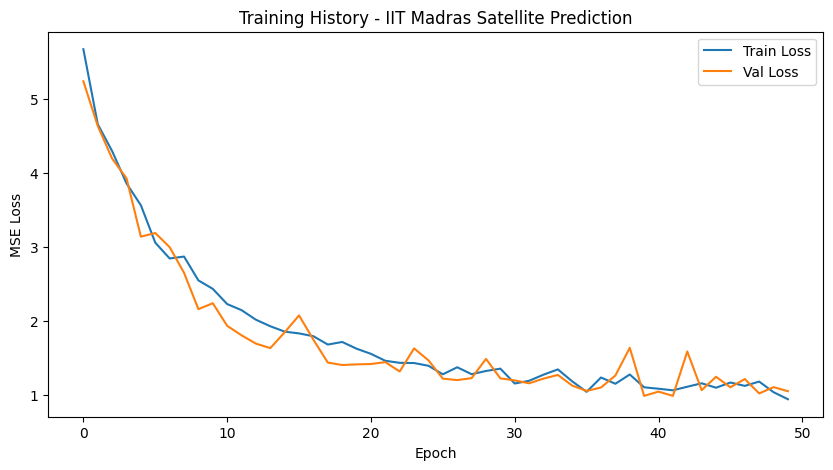

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History - IIT Madras Satellite Prediction')
plt.legend()
plt.show()


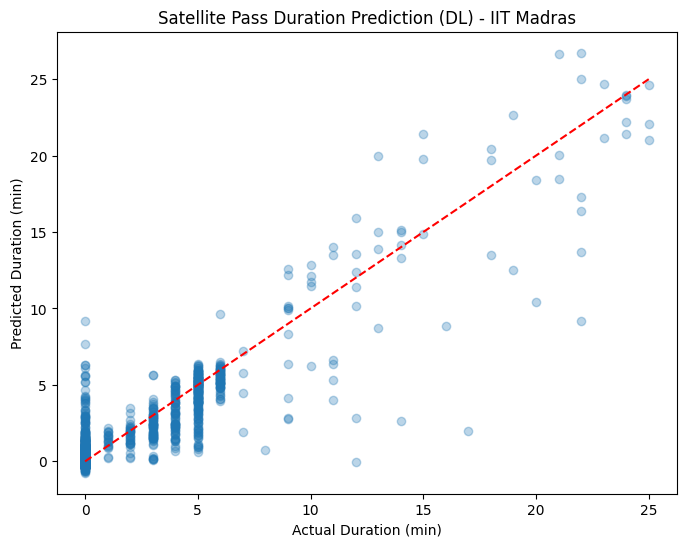

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_dl, alpha=0.3)
plt.xlabel("Actual Duration (min)")
plt.ylabel("Predicted Duration (min)")
plt.title("Satellite Pass Duration Prediction (DL) - IIT Madras")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.show()


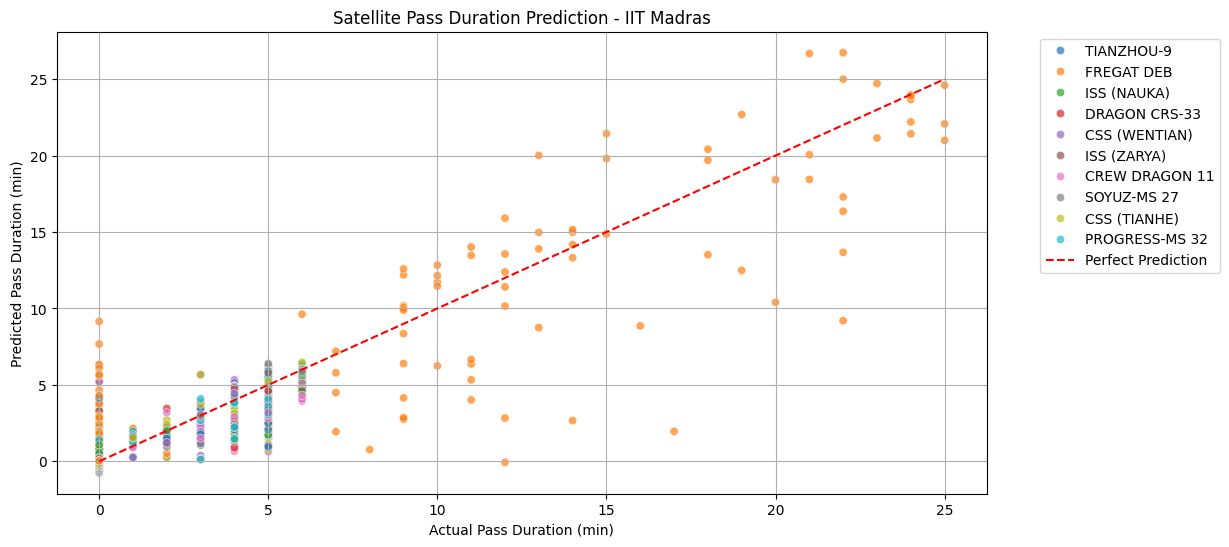

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame({
    'Satellite': X_test.index.map(lambda i: df.iloc[i]['Satellite']),
    'Actual_Duration': y_test,
    'Predicted_Duration': y_pred_dl
})

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=results_df,
    x='Actual_Duration',
    y='Predicted_Duration',
    hue='Satellite',
    palette='tab10',
    alpha=0.7
)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Pass Duration (min)")
plt.ylabel("Predicted Pass Duration (min)")
plt.title("Satellite Pass Duration Prediction - IIT Madras")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


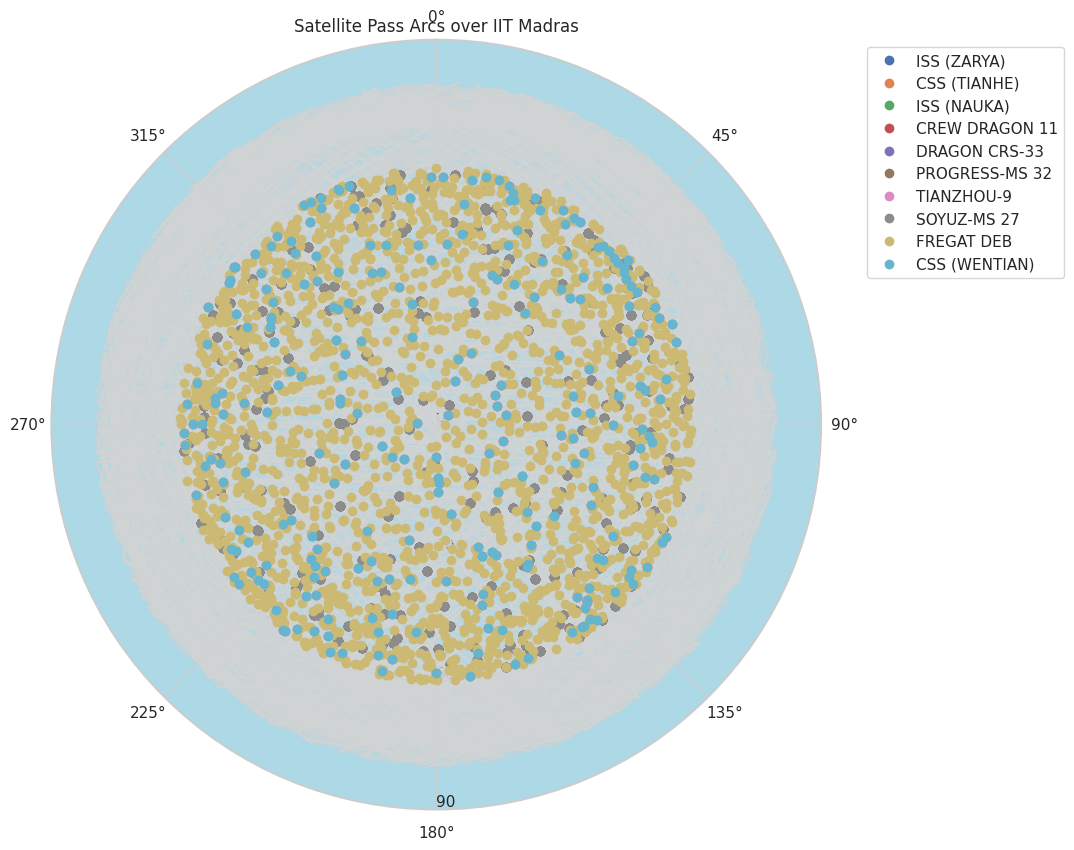

In [ ]:
#bonus
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)

df['Azimuth_rad'] = np.radians(df['Azimuth'])

for sat_name in df['Satellite'].unique():
    sat_data = df[df['Satellite'] == sat_name]
    alt_r = 90 - sat_data['Altitude']
    ax.plot(sat_data['Azimuth_rad'], alt_r, color='lightgray', alpha=0.3)

good_passes = df[df['Altitude'] > 30]
for sat_name in good_passes['Satellite'].unique():
    sat_data = good_passes[good_passes['Satellite'] == sat_name]
    alt_r = 90 - sat_data['Altitude']
    ax.plot(sat_data['Azimuth_rad'], alt_r, marker='o', linestyle='', label=sat_name)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)
ax.set_rticks([0, 30, 60, 90])
ax.set_rlabel_position(180)
ax.set_facecolor('lightblue')
plt.title("Satellite Pass Arcs over IIT Madras")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


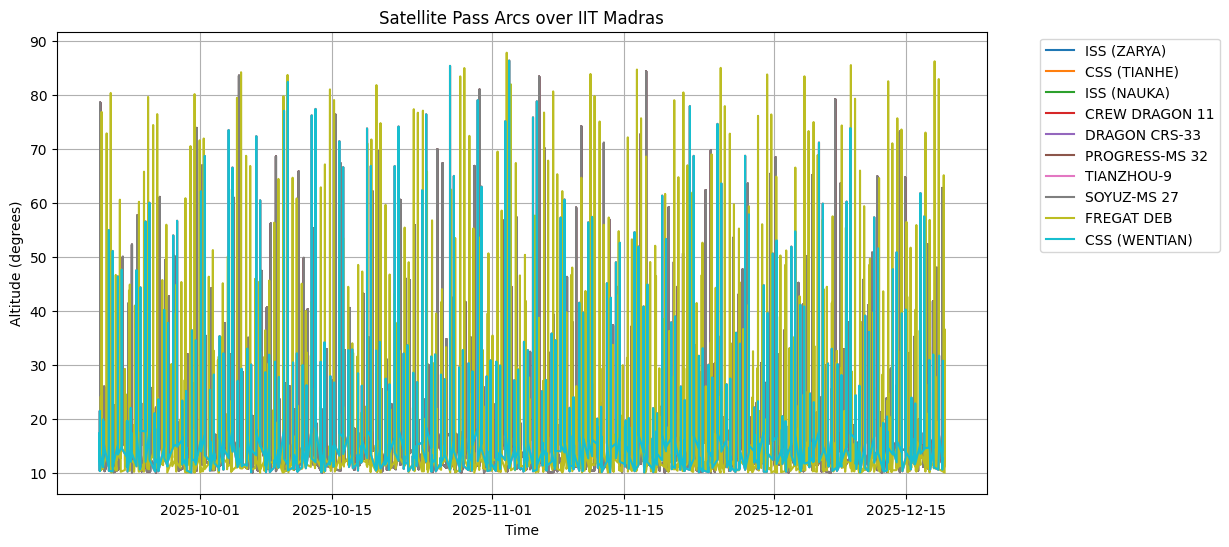

Good passes for communication:


,Satellite,Time,Max_Altitude,Pass_Duration_min
0,ISS (ZARYA),2025-09-20 08:20:00+00:00,84.43,128906.0
1,CSS (TIANHE),2025-09-20 05:45:00+00:00,86.40,129183.0
2,ISS (NAUKA),2025-09-20 08:20:00+00:00,84.43,128906.0
3,CREW DRAGON 11,2025-09-20 08:20:00+00:00,84.43,128906.0
4,DRAGON CRS-33,2025-09-20 08:20:00+00:00,84.43,128906.0
5,PROGRESS-MS 32,2025-09-20 08:20:00+00:00,84.43,128906.0
6,TIANZHOU-9,2025-09-20 05:45:00+00:00,86.40,129183.0
7,SOYUZ-MS 27,2025-09-20 08:20:00+00:00,84.43,128906.0
8,FREGAT DEB,2025-09-20 09:46:00+00:00,87.85,129208.0
9,CSS (WENTIAN),2025-09-20 05:45:00+00:00,86.40,129183.0


Visibility window for ISS (ZARYA):
{'Satellite': 'ISS (ZARYA)', 'Start_Time': Timestamp('2025-09-20 08:20:00+0000', tz='UTC'), 'End_Time': Timestamp('2025-12-18 20:46:00+0000', tz='UTC'), 'Total_Duration_min': 128906.0}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

df = df.copy()

plt.figure(figsize=(12, 6))
for sat in df['Satellite'].unique():
    sat_df = df[df['Satellite'] == sat]
    plt.plot(sat_df['Time'], sat_df['Altitude'], label=sat)
plt.xlabel('Time')
plt.ylabel('Altitude (degrees)')
plt.title('Satellite Pass Arcs over IIT Madras')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

good_passes_list = []

for sat in df['Satellite'].unique():
    sat_df = df[df['Satellite'] == sat].sort_values('Time')
    sat_df['Pass_Group'] = (sat_df['Altitude'] < 10).cumsum()  # group continuous passes

    for group, group_df in sat_df.groupby('Pass_Group'):
        max_alt = group_df['Altitude'].max()
        duration = (group_df['Time'].max() - group_df['Time'].min()).total_seconds() / 60
        if max_alt >= 45 and duration >= 5:
            good_passes_list.append({
                'Satellite': sat,
                'Time': group_df['Time'].min(),
                'Max_Altitude': max_alt,
                'Pass_Duration_min': duration
            })

good_passes_df = pd.DataFrame(good_passes_list)
print("Good passes for communication:")
display(good_passes_df)
def get_visibility_window(df, satellite_name):
    sat_df = df[df['Satellite'] == satellite_name].sort_values('Time')
    start_time = sat_df['Time'].min()
    end_time = sat_df['Time'].max()
    duration = (end_time - start_time).total_seconds() / 60
    return {
        'Satellite': satellite_name,
        'Start_Time': start_time,
        'End_Time': end_time,
        'Total_Duration_min': duration
    }

window = get_visibility_window(df, 'ISS (ZARYA)')
print("Visibility window for ISS (ZARYA):")
print(window)


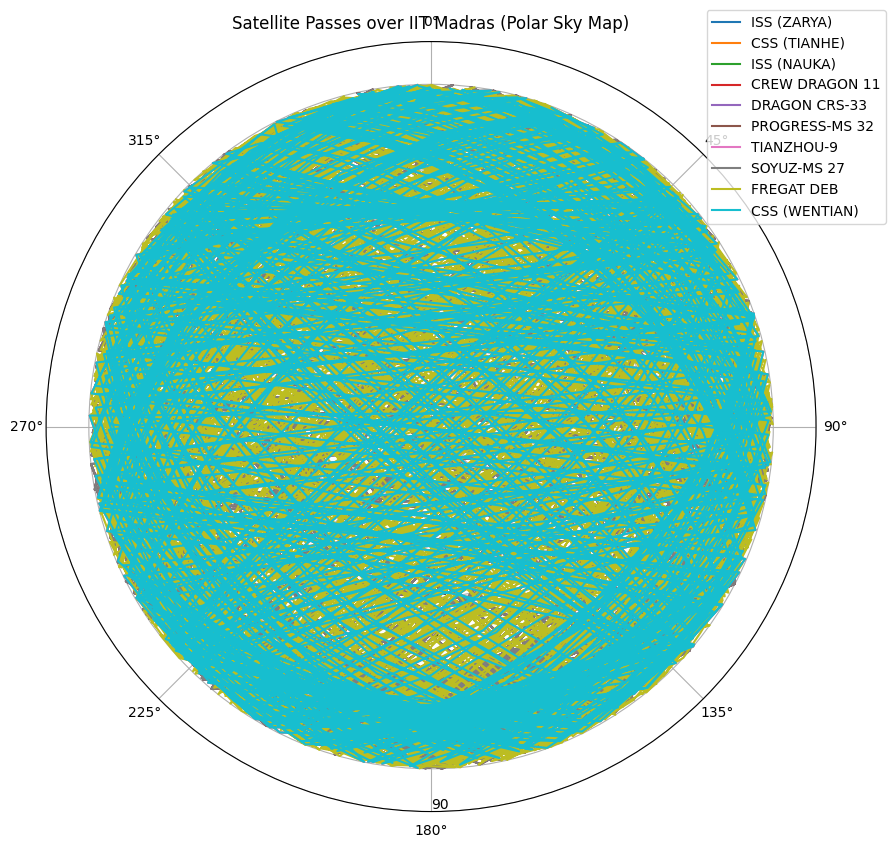

In [ ]:

# Polar Sky Map Visualization of Satellite Passes

import numpy as np

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

for sat in df['Satellite'].unique():
    sat_df = df[df['Satellite'] == sat]
    az = np.deg2rad(sat_df['Azimuth'].values)
    alt = 90 - sat_df['Altitude'].values
    ax.plot(az, alt, label=sat)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)
ax.set_rlabel_position(180)
ax.set_title('Satellite Passes over IIT Madras (Polar Sky Map)', va='bottom')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
